### TYK2 Assay Calibration

When considering the IFN-a DMS and FlowDMS data jointly, there are two separate decisions we want to make about each variant. First, considering FlowDMS or IFN-a DMS individually, we want to classify each variant as "significant" or "non-significant" in a particular direction in each individual assay. Second, we want to classify each variant jointly as "de/stabilizing" and/or "signaling-inhibited/-competent" using the data from both assays. This notebook prototypes several approaches to making these determinations. 

  1.  [FlowDMS Midpoint Calibration](#part1)
  2.  [Joint DMS/FlowDMS Calibration: Scaling](#part2)
  3.  [Joint DMS/FlowDMS Calibration: Meta-Analysis/Meta-Regression](#part3)

In [44]:
library(ggbeeswarm)
library(ggpubr)
library(knitr)
library(brms)
library(scales)
library(scico)
library(ggside)
library(patchwork)
library(tidyverse)

compute_difference <- function(test, control, sumstats) {
    
    df1 <- sumstats %>% filter(condition == test) %>% select(-condition)
    df2 <- sumstats %>% filter(condition == control) %>% select(-condition)
    
    df <- inner_join(df1, df2,
                     by = c("pos", "clone", "chunk", "aa", "version", "dispersion"))
    
    new_stats <- df %>%
        mutate(estimate = estimate.x - estimate.y,
               std.error = sqrt(std.error.x^2 + std.error.y^2)) %>%
        select(pos, clone, chunk, aa, estimate, std.error, dispersion, version) %>%
        ungroup()
    
    new_stats$condition = paste0(test, " - ", control)
    
    return(new_stats)
    
}

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

#### VAMP-seq Midpoint Calibration <a name="part1"></a>

For IFN-a DMS analyses, we have tested whether the mutant effect is significantly different from zero, which seems to produce sensible results. However, for FlowDMS, there appear to be a large number of variants with significantly non-zero, but small, midpoint shifts relative to wild-type. Thus, we want to draw a line somewhere, potentially not zero, to identify significant FlowDMS effects. We start by examining the underlying summary statistics, to see if there is any obvious cutoff point:

In [4]:
midpoint_sumstats <- read_tsv("../sumstats/TYK2-VAMP/midpoint/vamp-10-midpoint-sumstats.tsv")

Rows: 1400 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): mut_aa
dbl (8): score_mean, score_sd, pos, estimate, std.error, statistic, p.value,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
p1 <- midpoint_sumstats %>%
    select(-score_mean, -score_sd, -p.value, -p.adj) %>%
    pivot_longer(names_to = "term", values_to = "value", estimate:statistic) %>%
    mutate(term = factor(term, levels = c("estimate", "std.error", "statistic"))) %>%
    ggplot() +
        geom_quasirandom(aes(x = 1, y = value)) +
        theme_pubr(base_size = 16) +
        facet_wrap(~term, nrow = 1, scales = "free_y") +
        theme(axis.text.x = element_blank()) +
        xlab("") +
        ggtitle("Effect Sizes and Errors")

p2 <- ggplot(midpoint_sumstats) +
    geom_histogram(aes(x = p.value), fill = "black", color = "black", bins = 100) +
    theme_pubr(base_size = 16) +
    ggtitle("Raw p-values") +
    xlab("")

p3 <- ggplot(midpoint_sumstats) +
    geom_histogram(aes(x = p.adj), fill = "black", color = "black", bins = 100) +
    theme_pubr(base_size = 16) +
    ggtitle("Adjusted p-values") +
    xlab("")

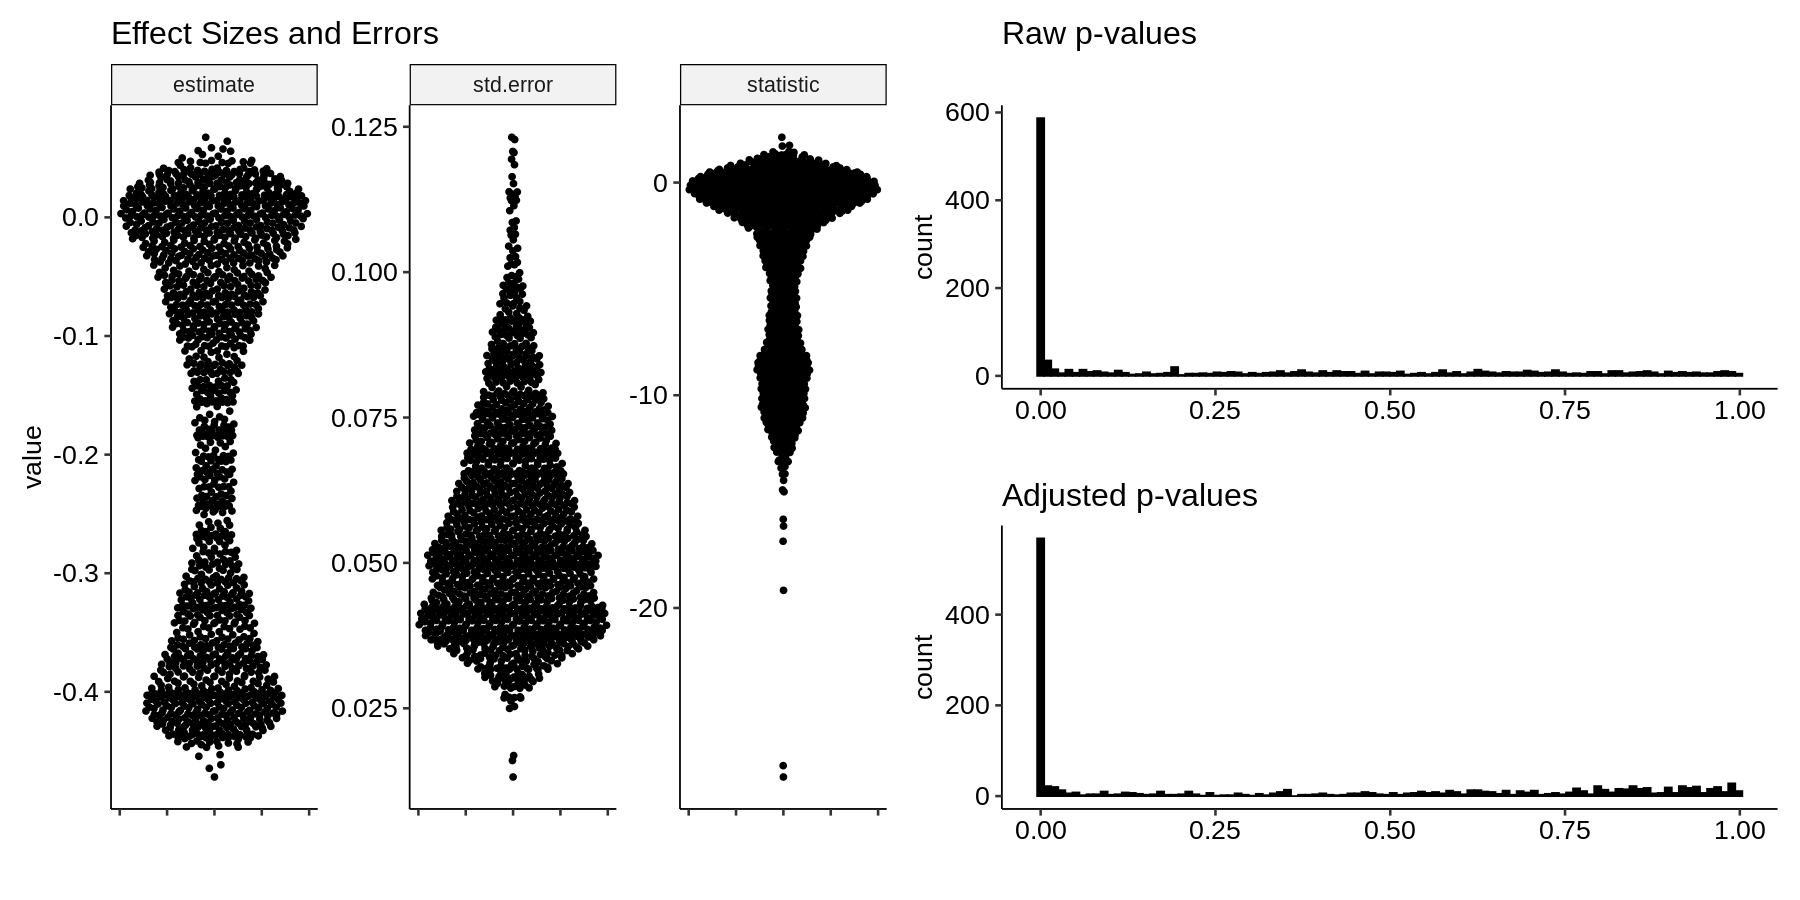

In [6]:
options(repr.plot.width = 15, repr.plot.height = 7.5)
p1 + (p2/p3)

Given the standard error distribution, there appears to be a meaningful threshold at approximately -0.25, reflected in the bulge past that point in the distributions of both the midpoint shifts and the test statistics. Since we often use stop effects to calibrate loss-of-function effects (and we don't see much GoF here), we can see if stops are generally below -0.25:

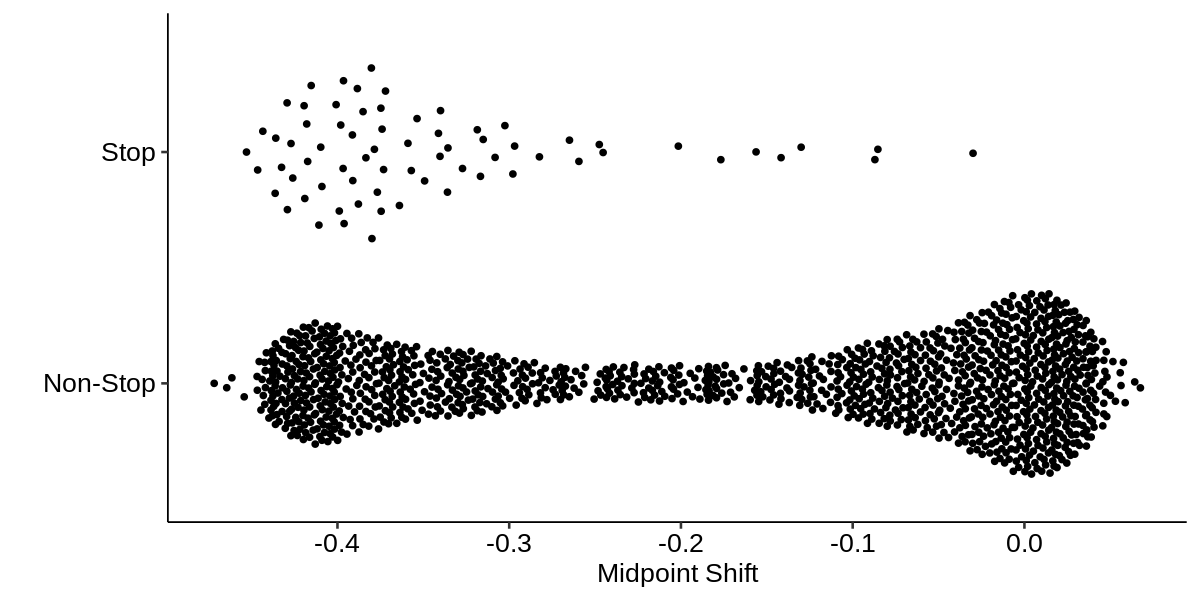

In [7]:
options(repr.plot.width = 10, repr.plot.height = 5)
midpoint_sumstats %>%
    mutate(group = if_else(mut_aa == "*", "Stop", "Non-Stop")) %>%
    ggplot() +
        geom_quasirandom(aes(x = group, y = estimate)) +
        theme_pubr(base_size = 16) +
        coord_flip() +
        xlab("") +
        ylab("Midpoint Shift")

To see if there is anything special about the less-negative stops, we can plot them across the chunk:

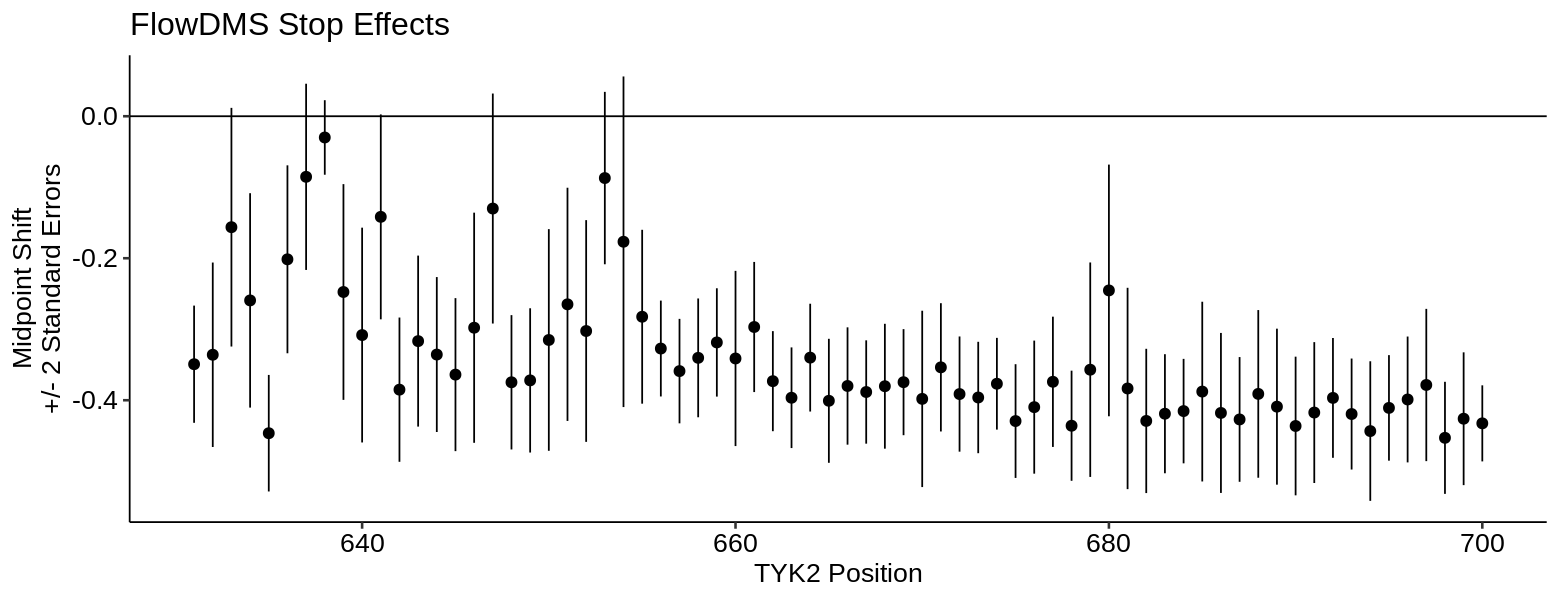

In [8]:
options(repr.plot.width = 13, repr.plot.height = 5)
midpoint_sumstats %>%
    filter(mut_aa == "*") %>%
    ggplot() +
        geom_pointrange(aes(x = pos, y = estimate,
                            ymin = estimate - 2*std.error,
                            ymax = estimate + 2*std.error)) +
        theme_pubr(base_size = 16) +
        xlab("TYK2 Position") + ylab("Midpoint Shift\n+/- 2 Standard Errors") +
        geom_hline(yintercept = 0) +
        ggtitle("FlowDMS Stop Effects")

Generally, we test whether a variant effect (defined as a mutant compared to WT) is different from zero. Here, we can evaluate what varying that threshold would do to the resulting summary statistics. Below, we test against the indicated "expected" or "null" midpoint shifts and show the resulting `-log10(unadjusted p-value)`. This is used instead of the Z-statistic directly, since we do not want weakly positive variants to be "significant" here just because we are testing against a negative null hypothesis:

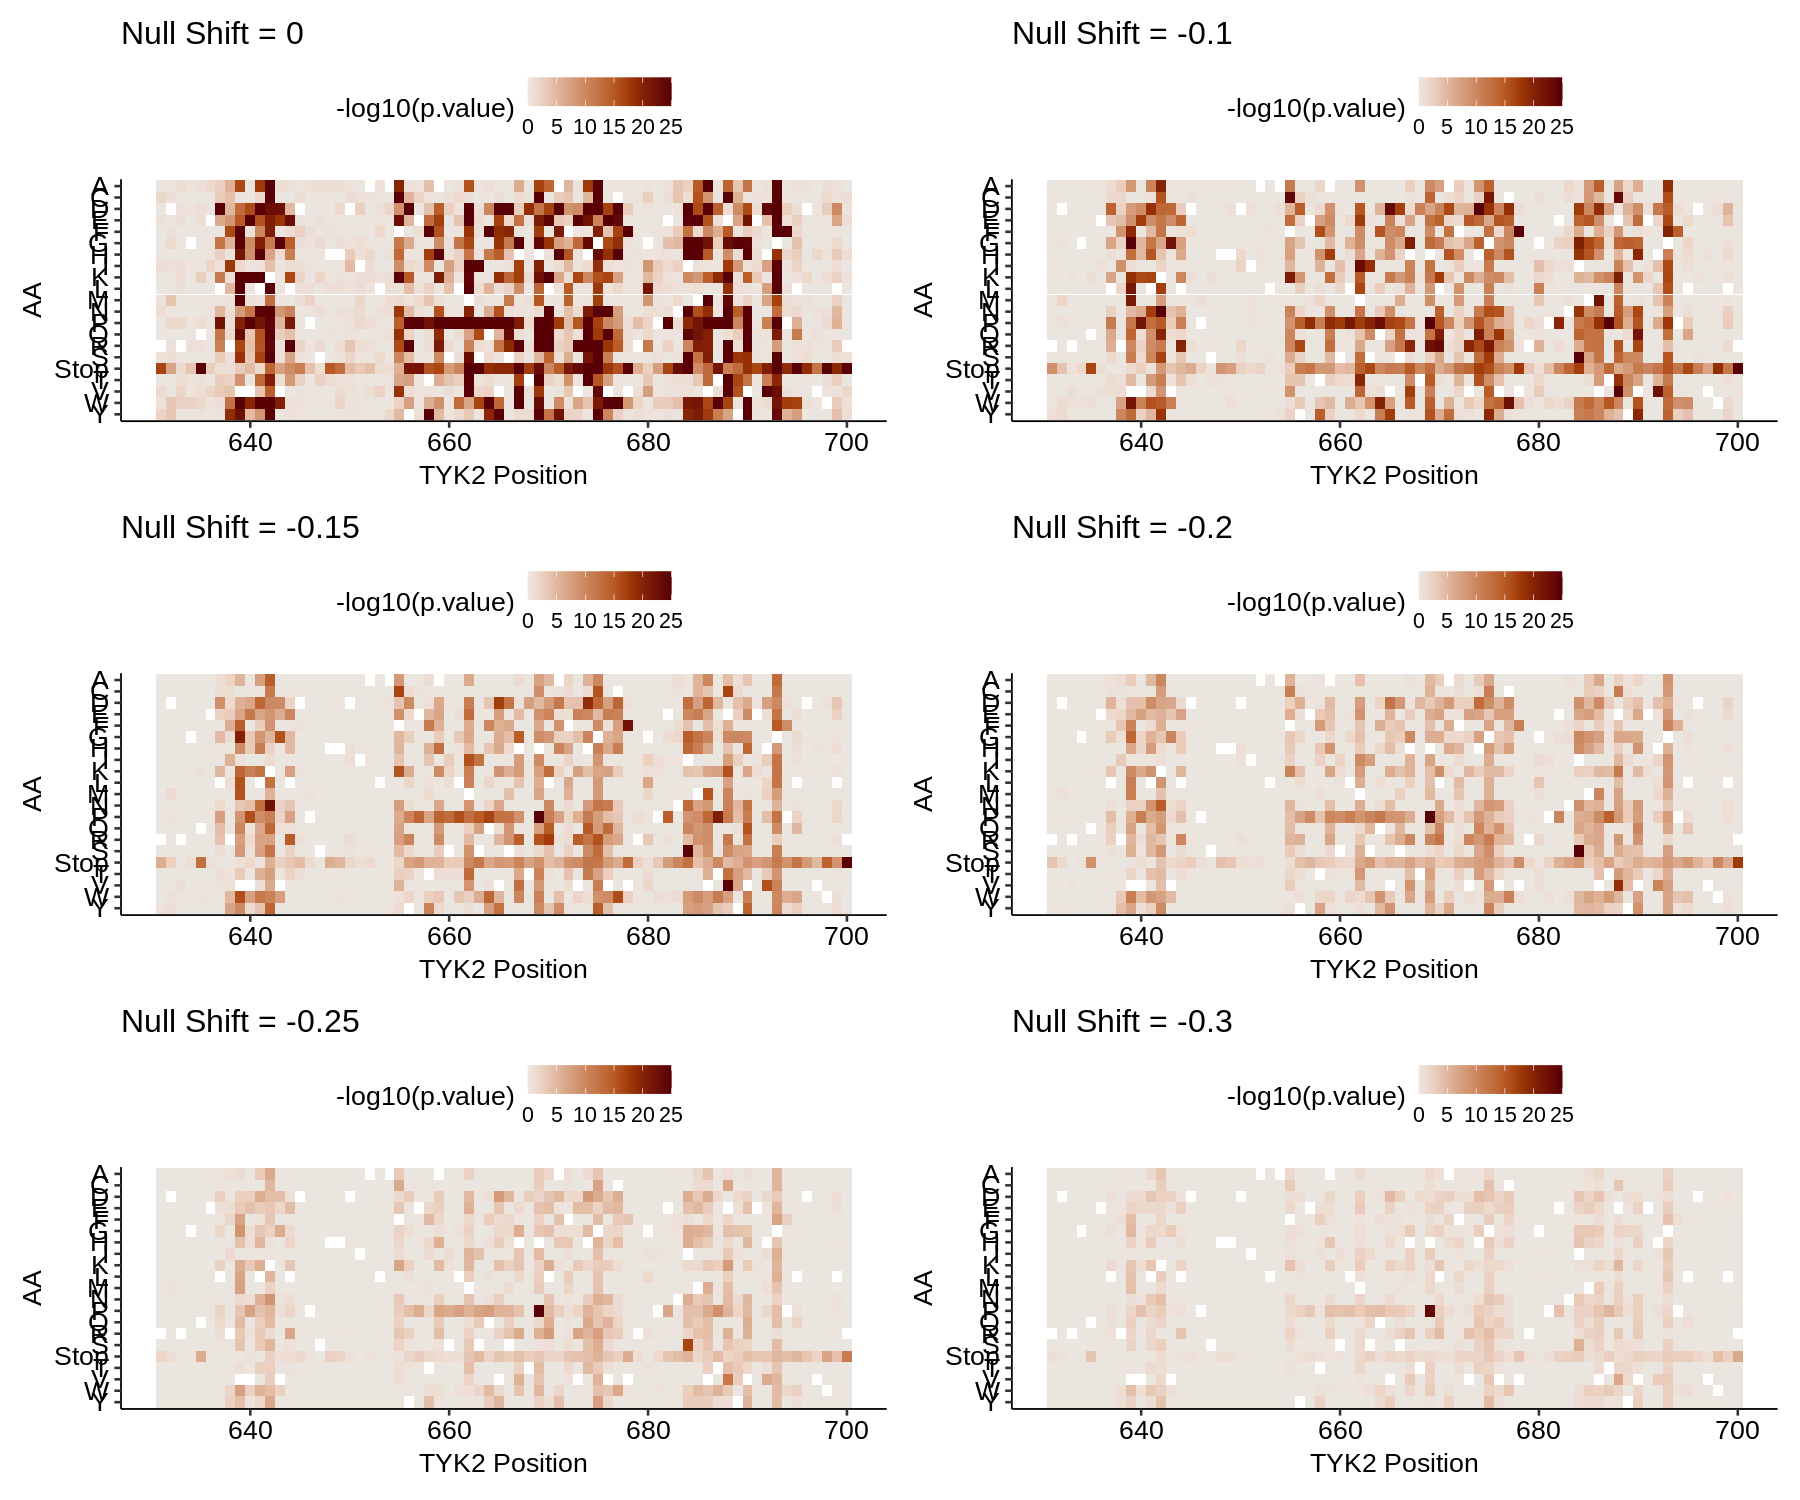

In [9]:
gen_thresh_heat <- function(thresh){
    sample_stats_test <- midpoint_sumstats %>%
        filter(mut_aa != "WT") %>%
        mutate(estimate = score_mean - 0.6756316 - thresh,
               std.error = sqrt(score_sd^2 + 0.005852742^2),
               statistic = estimate/std.error,
               p.value = pnorm(statistic, mean = 0, sd = 1),
               p.adj = p.adjust(p.value, method = "BH"))
    
    sample_stats_test %>%
        mutate(mut_aa = if_else(mut_aa == "*", "Stop", mut_aa)) %>%
        ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(mut_aa), fill = -log10(p.value))) +
            theme_pubr(base_size = 16) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish, limits = c(0,25)) +
            ggtitle(str_c("Null Shift = ", thresh)) +
            xlab("TYK2 Position") + ylab("AA")
}

options(repr.plot.width = 15, repr.plot.height = 12.5)
wrap_plots(map(c(0, -0.1, -0.15, -0.2, -0.25, -0.3), ~gen_thresh_heat(.)),
           ncol = 2)

#### Joint DMS/FlowDMS Calibration: Scaling <a name="part2"></a>

Above, we have a knob to tune the magnitude of an effect required to achieve significance for FlowDMS. Now, we would like to jointly evaluate the relationship between these FlowDMS summary statistics and the IFN-alpha DMS dataset. If we plot the summary statistics we usually use, the log2 fold change and the midpoint shift, we get the following:

In [10]:
dms <- read_tsv("../sumstats/TYK2/run7/tyk2-assay7.tsv") %>%
    filter(condition == "IFNalpha100_0 - None_0", chunk == 10) %>%
    select(pos, aa, estimate, std.error, statistic, p.value, p.adj) %>%
    mutate(fc = 2^estimate)

combined <- inner_join(dms,
                       midpoint_sumstats,
                       by = c("pos" = "pos", "aa" = "mut_aa"))

base_plot <- ggplot(combined) +
    geom_point(aes(x = estimate.x, y = estimate.y,
                   color = if_else(aa == "*", "red", "black"),
                   size = if_else(aa == "*", 3, 1.5))) +
    theme_pubr(base_size = 16) +
    geom_abline(slope = 1, intercept = 0) +
    scale_color_identity() +
    scale_size_identity() +
    xlab("IFN-a DMS Log2FoldChange") +
    ylab("FlowDMS Midpoint Shift")

Rows: 94876 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): drug, clone, chunk, aa, version, condition
dbl (8): conc, pos, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


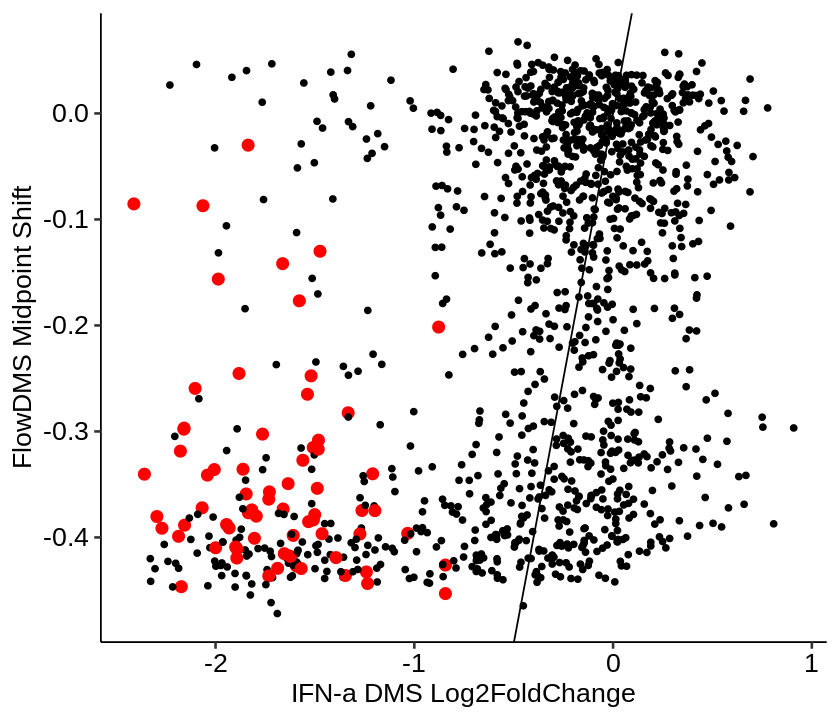

In [11]:
options(repr.plot.width = 7, repr.plot.height = 6)
base_plot 

It makes sense that these aren't particularly well related, since they're fundamentally different quantities. We would like to rescale these values so they are more comparable. To start, since the midpoint is essentially a ratio (though not a mutant to WT ratio), we could work with the fold change itself instead of the log2 fold change. **Then, the DMS WT value becomes 1.**

Similarly, instead of the midpoint shift, we could work with the raw midpoint itself. **Then, the FlowDMS WT value becomes 0.657**

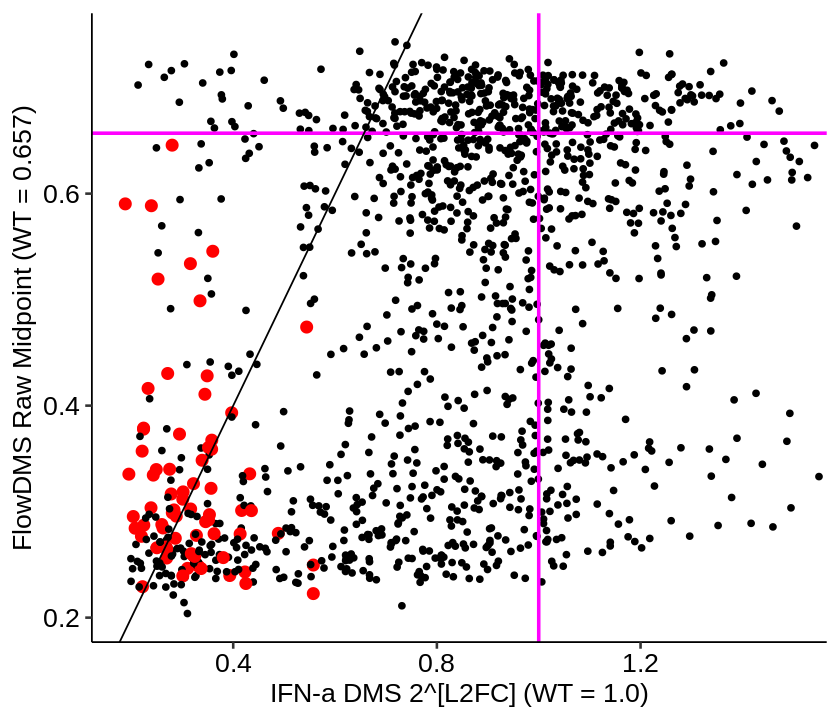

In [12]:
base_plot_exp <- ggplot(combined) +
    geom_point(aes(x = fc,
                   y = score_mean,
                   color = if_else(aa == "*", "red", "black"),
                   size = if_else(aa == "*", 3, 1.5))) +
    theme_pubr(base_size = 16) +
    geom_hline(yintercept = 0.657, color = "magenta", linewidth = 1) +
    geom_vline(xintercept = 1, color = "magenta", linewidth = 1) +
    geom_abline(slope = 1, intercept = 0) +
    scale_color_identity() +
    scale_size_identity() +
    xlab("IFN-a DMS 2^[L2FC] (WT = 1.0)") +
    ylab("FlowDMS Raw Midpoint (WT = 0.657)") +
    coord_cartesian(xlim = c(NA, 1.5))

base_plot_exp

If we find the median stop effect for the DMS fold change and FlowDMS raw midpoint, we obtain strikingly similar values:

In [13]:
combined %>%
    filter(aa == "*") %>%
    summarize("DMS Stop Median" = median(fc),
              "FlowDMS Stop Median" = median(score_mean)) %>%
    kable("markdown")



| DMS Stop Median| FlowDMS Stop Median|
|---------------:|-------------------:|
|       0.3131436|           0.3009936|

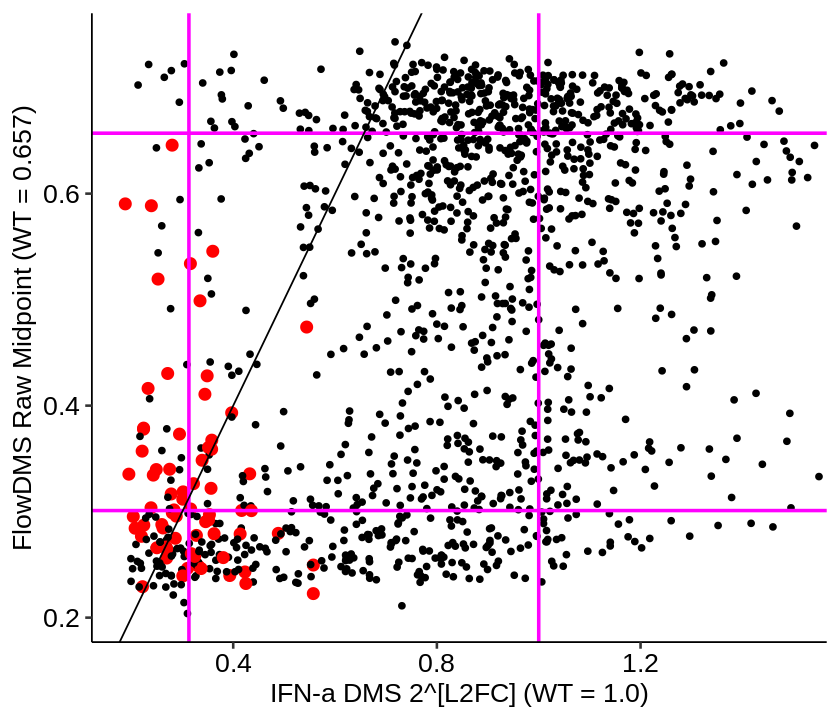

In [14]:
base_plot_exp <- ggplot(combined) +
    geom_point(aes(x = fc,
                   y = score_mean,
                   color = if_else(aa == "*", "red", "black"),
                   size = if_else(aa == "*", 3, 1.5))) +
    theme_pubr(base_size = 16) +
    geom_hline(yintercept = c(0.657, 0.301), color = "magenta", linewidth = 1) +
    geom_vline(xintercept = c(1, 0.313), color = "magenta", linewidth = 1) +
    geom_abline(slope = 1, intercept = 0) +
    scale_color_identity() +
    scale_size_identity() +
    xlab("IFN-a DMS 2^[L2FC] (WT = 1.0)") +
    ylab("FlowDMS Raw Midpoint (WT = 0.657)") +
    coord_cartesian(xlim = c(NA, 1.5))

base_plot_exp

This is looking better - the stop effect seems naturally well calibrated between both assays. Now, we need to equalize the WT effect while holding the stop effect fixed. The easiest way to do that is by applying the following min-max transformation to each assay:

$$ \frac{value - median(stop)}{WT - median(stop)} $$

Where $WT$ and $stop$ are the point estimates of the WT and stop scores.

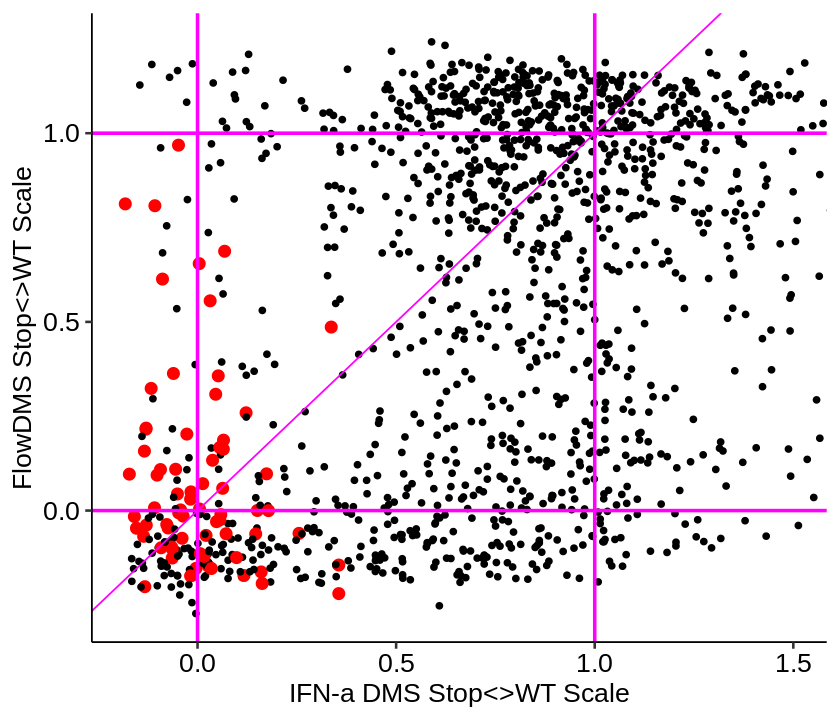

In [15]:
base_plot_minmax <- ggplot(combined) +
    geom_point(aes(x = (fc - 0.313)/(1-0.313),
                   y = (score_mean-0.301)/(0.657-0.301),
                   color = if_else(aa == "*", "red", "black"),
                   size = if_else(aa == "*", 3, 1.5))) +
    theme_pubr(base_size = 16) +
    geom_hline(yintercept = c(1, 0), color = "magenta", linewidth = 1) +
    geom_vline(xintercept = c(1, 0), color = "magenta", linewidth = 1) +
    geom_abline(slope = 1, intercept = 0, color = "magenta") +
    scale_color_identity() +
    scale_size_identity() +
    xlab("IFN-a DMS Stop<>WT Scale") +
    ylab("FlowDMS Stop<>WT Scale") +
    coord_cartesian(xlim = c(NA, 1.5))

base_plot_minmax

The remaining challenge is to propagate error sufficiently through these transformation to do inference such that we could test for a difference between these two quantities being non-zero. This may not require considering WT error since it is so small relative to the variants themselves, but exponentiation means it cannot be directly computed using the original standard errors.

#### Joint DMS/FlowDMS Calibration: Meta-Analysis/Meta-Regression <a name="part3"></a>

An alternative approach for profiling assay differences uses tools like meta-regression to model the global relationship between the estimates and errors from both assays on their own terms, and then uses that relationship to identify points which are outside the global pattern. The effect size estimates and their confidence intervals are shown below:

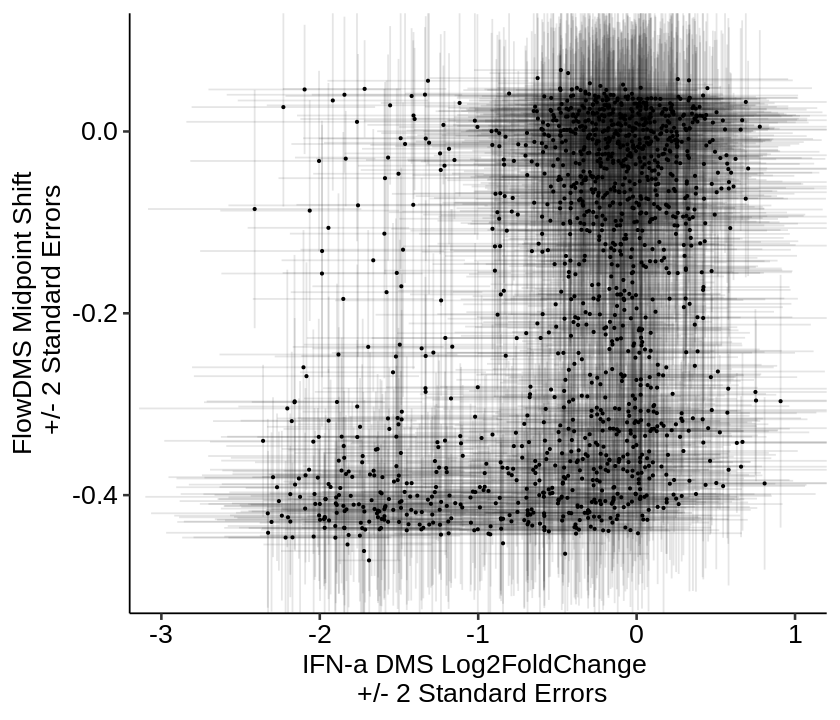

In [16]:
ggplot(combined) +
    geom_point(aes(x = estimate.x, y = estimate.y), size = 0.5) +
    geom_linerange(aes(x = estimate.x,
                       ymin = estimate.y - 2*std.error.y,
                       ymax = estimate.y + 2*std.error.y), alpha = 0.1) +
    geom_linerange(aes(y = estimate.y,
                       xmin = estimate.x - 2*std.error.x,
                       xmax = estimate.x + 2*std.error.x), alpha = 0.1) +
    theme_pubr(base_size = 16) +
    coord_cartesian(xlim = c(-3,1),
                    ylim = c(-0.5,0.1)) +
    xlab("IFN-a DMS Log2FoldChange \n +/- 2 Standard Errors") +
    ylab("FlowDMS Midpoint Shift\n +/- 2 Standard Errors")

Since we have meaningful error bars in both directions, we need a dual error-in-predictor and error-in-response model:

$$ midpoint\ shift | error \sim L2FC | error $$

Where we consider the point estimates and their error bars jointly. This is complex analytically (but may be tractable), but straightforward using Bayesian meta-regression. The specific call to `brms` is shown below, where we have errors in both the predictor via `me()` and in the response via `se()`:

In [104]:
priors <- prior(normal(0,1), class = b)

mod <- brm(formula = estimate.y | se(std.error.y, sigma = TRUE) ~ 0 + me(estimate.x, std.error.x),
           data = combined,
           prior = priors,
           backend = "cmdstanr",
           cores = 4,
           chains = 4)

summary(mod)

Start sampling



 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: estimate.y | se(std.error.y, sigma = TRUE) ~ 0 + me(estimate.x, std.error.x) 
   Data: combined (Number of observations: 1400) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
                        Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
meestimate.xstd.error.x     0.27      0.01     0.26     0.29 1.00     2641
                        Tail_ESS
meestimate.xstd.error.x     2751

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.16      0.00     0.15     0.17 1.00     2695     2640

Draws were sampled using sample(hmc). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [105]:
pred <- predict(mod, cores = 30) %>% as_tibble()

Warning message:
“Noise-free latent variables were not saved. You can control saving those variables via 'save_pars()'. Treating original data as if it was new data as a workaround.”


The estimated slope is 0.27, which makes sense given the previous plot. We compute the prediction intervals for each variant, meaning the prediction of the model given a particular DMS effect size and standard error. Since this is a Bayesian model, these are evaluated by sampling, so we also have a 95% confidence interval on each predicted variant:

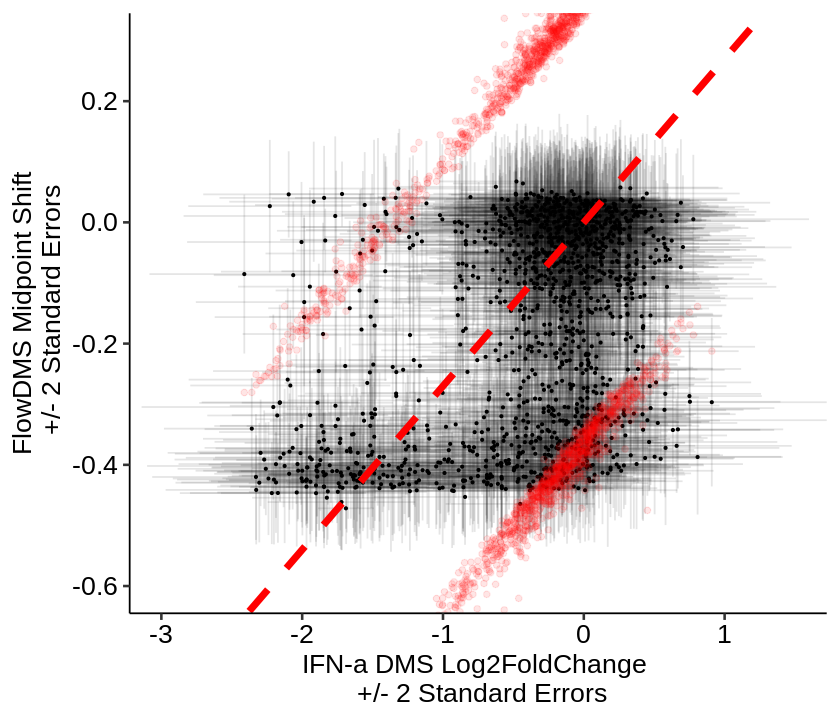

In [108]:
ggplot(combined) +
    geom_point(aes(x = estimate.x, y = estimate.y), size = 0.5) +
    geom_linerange(aes(x = estimate.x,
                       ymin = estimate.y - 2*std.error.y,
                       ymax = estimate.y + 2*std.error.y), alpha = 0.1) +
    geom_linerange(aes(y = estimate.y,
                       xmin = estimate.x - 2*std.error.x,
                       xmax = estimate.x + 2*std.error.x), alpha = 0.1) +
    geom_abline(slope = 0.27, intercept = 0,
                color = "red", linetype = "dashed", linewidth = 2) +
    geom_point(aes(x = estimate.x,
                  y = pred$Q2.5), color = "red", alpha = 0.1) +
    geom_point(aes(x = estimate.x,
                  y = pred$Q97.5), color = "red", alpha = 0.1) +
    theme_pubr(base_size = 16) +
    coord_cartesian(xlim = c(-3,1.5),
                    ylim = c(-0.6,0.3)) +
    xlab("IFN-a DMS Log2FoldChange \n +/- 2 Standard Errors") +
    ylab("FlowDMS Midpoint Shift\n +/- 2 Standard Errors")

From the variant set, it is simple to extract those whose actual interval does not overlap the predicted interval:

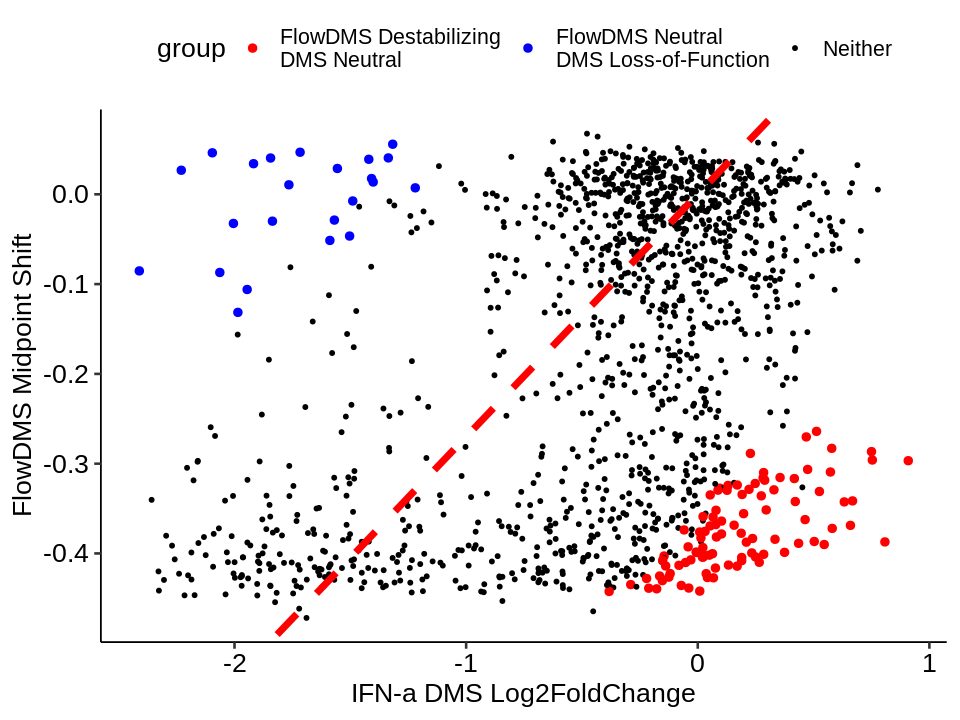

In [143]:
options(repr.plot.width = 8, repr.plot.height = 6)
bind_cols(combined, pred) %>% 
    mutate(group = case_when(estimate.y < Q2.5 ~ "FlowDMS Destabilizing\nDMS Neutral",
                             estimate.y > Q97.5 ~ "FlowDMS Neutral\nDMS Loss-of-Function",
                             TRUE ~ "Neither")) %>%
    ggplot() +
        geom_point(aes(x = estimate.x, y = estimate.y,
                       color = group, size = group)) +
    geom_abline(slope = 0.27, intercept = 0,
                color = "red", linetype = "dashed", linewidth = 2) +
    theme_pubr(base_size = 16) +
    xlab("IFN-a DMS Log2FoldChange") +
    ylab("FlowDMS Midpoint Shift") +
    scale_color_manual(values = c("red", "blue", "black")) +
    scale_size_manual(values = c(2, 2, 1))

We can extract and pile up the variants in the upper and lower cluster, respectively, and show them on a heatmap to get a sense of their positional distribution:

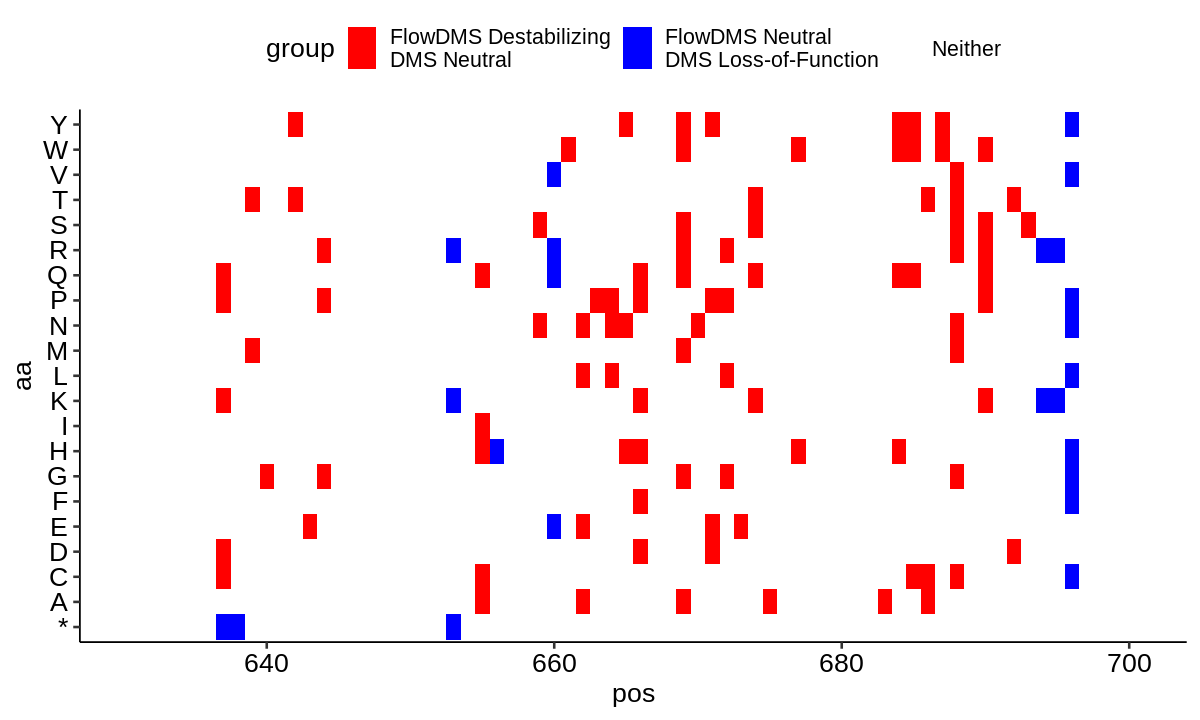

In [138]:
options(repr.plot.width = 10, repr.plot.height = 6)
bind_cols(combined, pred) %>% 
    mutate(group = case_when(estimate.y < Q2.5 ~ "FlowDMS Destabilizing\nDMS Neutral",
                             estimate.y > Q97.5 ~ "FlowDMS Neutral\nDMS Loss-of-Function",
                             TRUE ~ "Neither")) %>%
    ggplot() +
        geom_tile(aes(x = pos, y = aa, fill = group)) +
        theme_pubr(base_size = 16)  +
        scale_fill_manual(values = c("red", "blue", "white"))

There are many caveats on this result, but one consistent outcome of all these approaches is that there are many more variants that show evidence of destabilization by FlowDMS, but no functional effect in the IFN-alpha DMS assay. This does not seem explicable (as of yet) as a calibration issue - examining the underlying raw data for several spike-ins in this class is very convincing. Four spike-ins provide a good way to evaluate this:

In [229]:
raw_vamp <- read_tsv("../sumstats/TYK2-VAMP/midpoint/tyk2-vamp-mini_10-vampseq.sumstats.tsv")
raw_dms <- read_tsv("../sumstats/TYK2/run7/tyk2-assay7-unnormalized.tsv")

plot_variant <- function(position, residue){

    p1 <- raw_vamp %>%
        filter(grepl(str_c("mut_aa", residue), term, fixed = TRUE), pos == position) %>%
        mutate(term = gsub("condition_conc|mut_aa", "", term)) %>%
        separate(term, c("bin", "aa"), sep = ":") %>%
        mutate(bin = factor(bin, levels = c(25, 50, 75, 100))) %>%
        ggplot() +
            geom_pointrange(aes(x = bin, y = estimate,
                                ymin = estimate - 2*std.error,
                                ymax = estimate + 2*std.error)) +
            theme_pubr(base_size = 16) +
            geom_hline(yintercept = 0) +
            xlab("GFP Sorted Bin") + ylab("Log2FoldChange\n+/- 2 Standard Errors") +
            ggtitle(str_c("FlowDMS ", position, residue )) + ylim(c(-1, 1))

    p2 <- raw_dms %>%
        filter(pos == position, aa == residue) %>%
        ggplot() +
            geom_pointrange(aes(x = condition, y = estimate,
                                ymin = estimate - 2*std.error,
                                ymax = estimate + 2*std.error)) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            geom_hline(yintercept = 0) + ylab("Log2FoldChange\n+/- 2 Standard Errors") +
            ggtitle(str_c("IFN-a DMS ", position, residue)) + xlab("") + ylim(c(-2, 2))
    
    the_plot <- p1 / p2

    return(the_plot)
}

Rows: 11830 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): effect, component, group, term, mut_aa, version
dbl (9): chunk, pos, estimate, std.error, statistic, p.value, dispersion, co...
lgl (1): clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 118595 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): clone, chunk, condition, aa, version, drug
dbl (8): pos, estimate, std.error, statistic, p.value, dispersion, conc, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


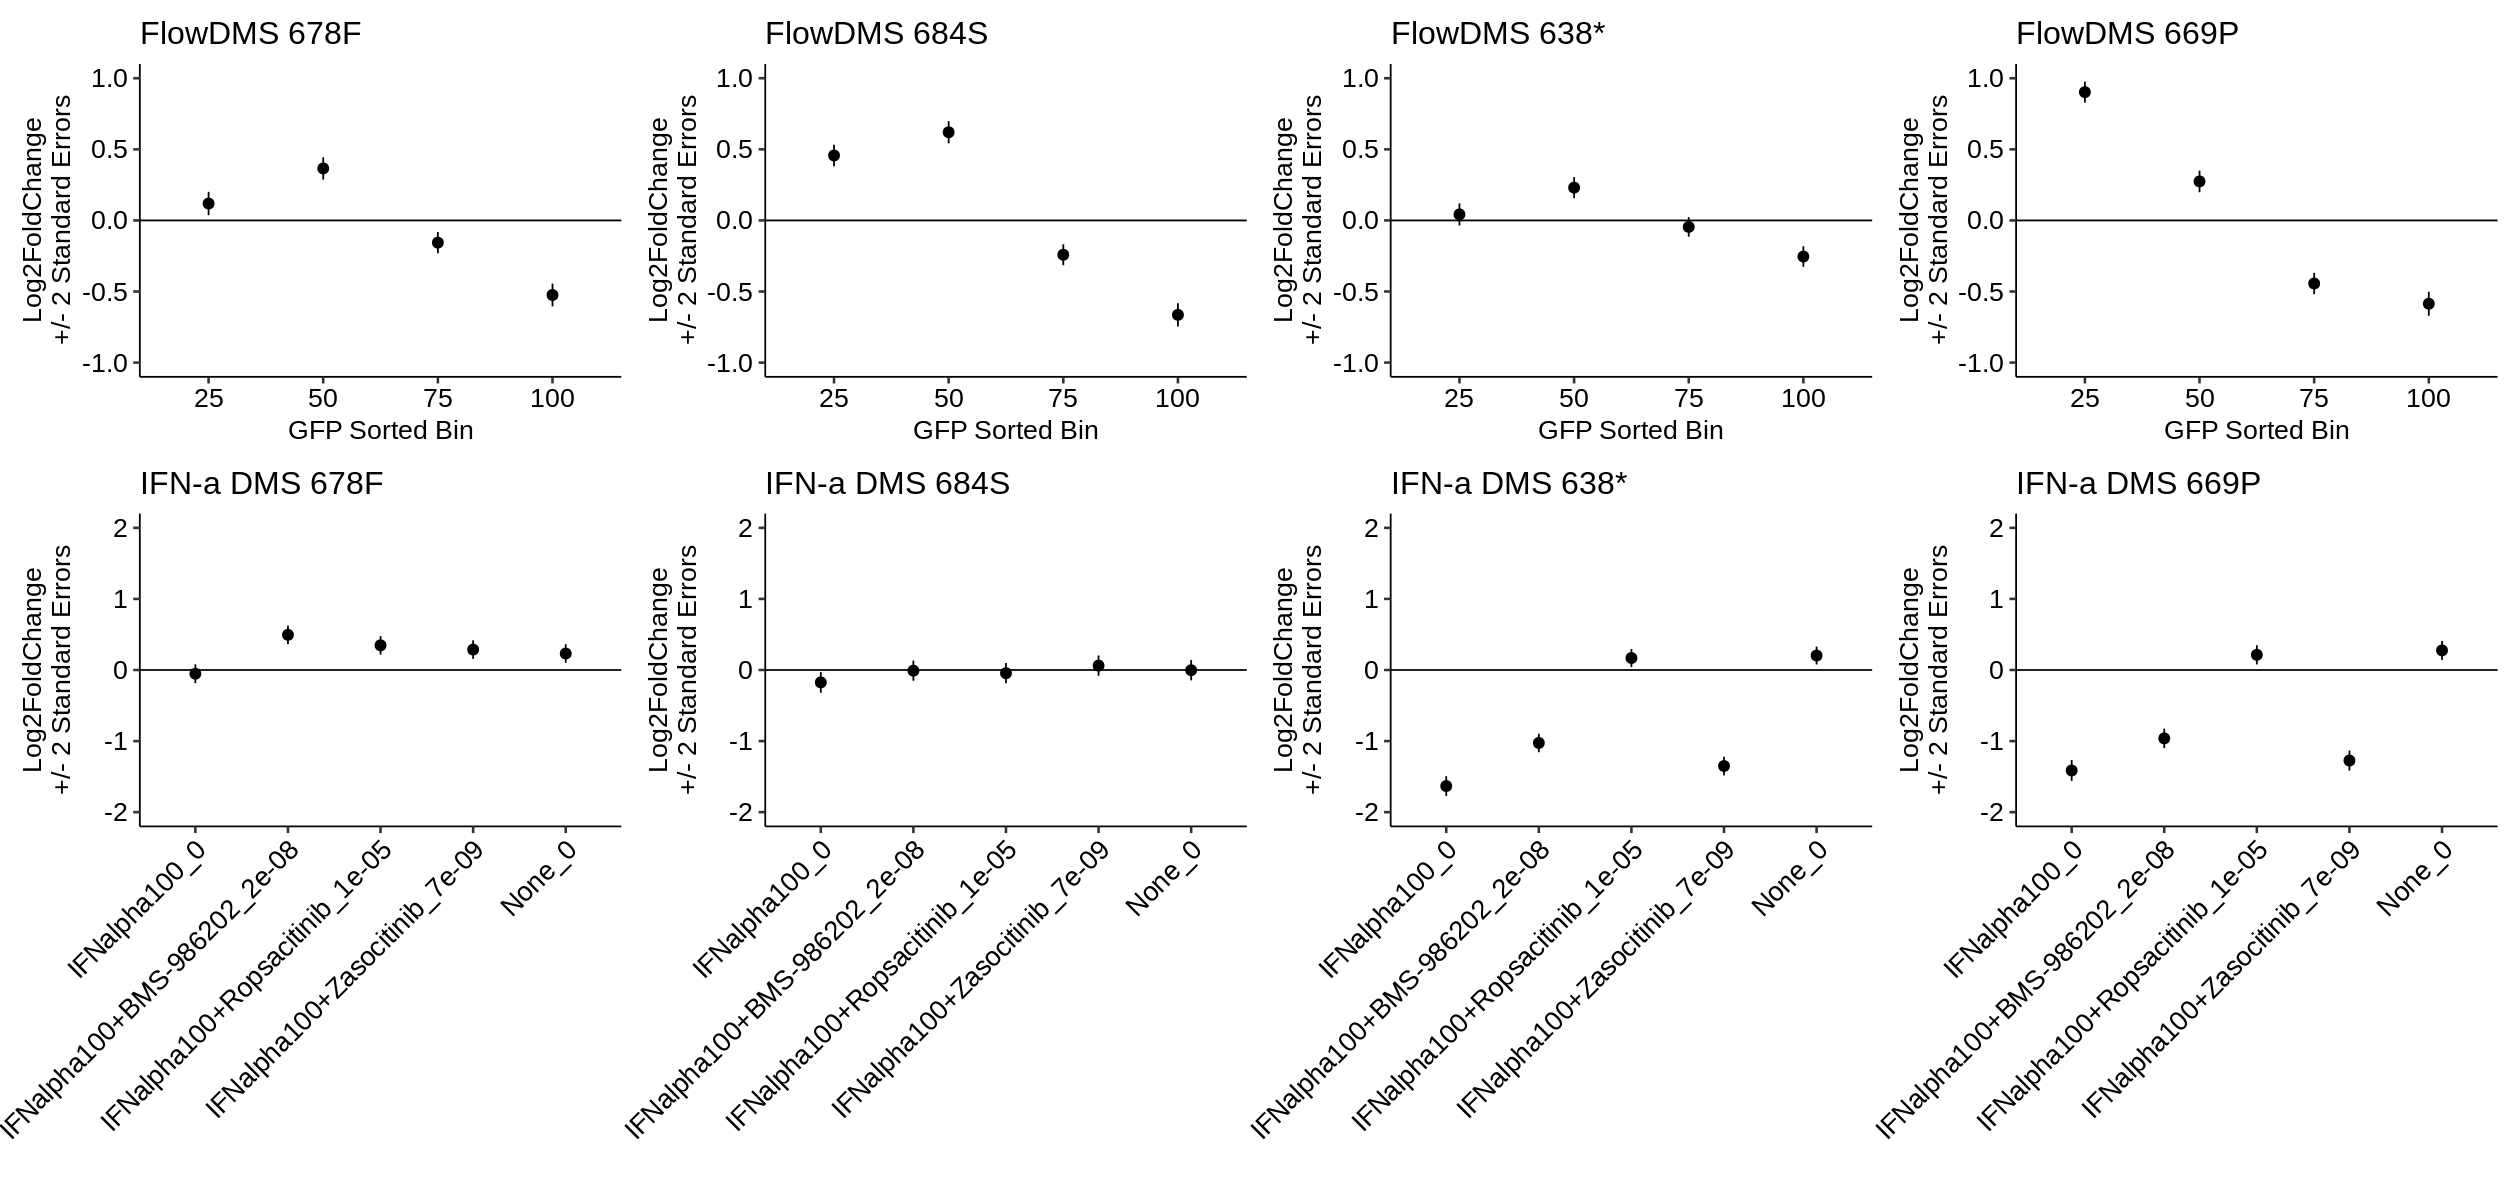

In [233]:
options(repr.plot.width = 21, repr.plot.height = 10)
plot_variant(678, "F") | plot_variant(684, "S") | plot_variant(638, "*") | plot_variant(669, "P")